In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
# Loading the dataset
df = pd.read_csv('data.csv', delimiter=';')

# Exploratory Data Analysis

In [3]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [4]:
# Removing the 'id' column and dropping rows with missing values
df = (df.drop('id', axis = 1)).dropna()

#### I removed the 'id' values as they are not related to 'cardio'. 

In [5]:
# Displaying the first few rows of the cleaned dataset
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
# Displaying the shape of the cleaned dataset 
df.shape

(70000, 12)

In [7]:
# Displaying the data types of each column
df.dtypes

age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [8]:
# Splitting the data into features (X) and target variable (y)
X = df.drop('cardio', axis = 1)
y = df['cardio']


In [9]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)

In [10]:
# Displaying the target variable of the training set
y_train

58414    1
49691    0
8653     1
8945     1
38360    0
        ..
55985    1
32399    1
60620    0
34086    1
58067    0
Name: cardio, Length: 56000, dtype: int64

# Scaling the features using MinMaxScaler, StandardScaler, and RobustScaler

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

scaler_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
scaled_datasets = {}
scalers = {}

for scaler_type in [MinMaxScaler, StandardScaler, RobustScaler]:
    scaler = scaler_type()
    scaled = X_train.copy()
    scaled[scaler_features] = scaler.fit_transform(X_train[scaler_features])
    scaled_datasets[scaler_type.__name__] = scaled
    scalers[scaler_type.__name__] = scaler

# Extracting scaled datasets
X_train_minmax_scaled = scaled_datasets['MinMaxScaler']
X_train_standard_scaled = scaled_datasets['StandardScaler']
X_train_robust_scaled = scaled_datasets['RobustScaler']


In [12]:
# Function to scale the test data
def scale_test_data(X_test, scaler):
    X_test_scaled = X_test.copy()
    X_test_scaled[scaler_features] = scaler.transform(X_test[scaler_features])
    return X_test_scaled

# Scaling the test data using the previously fitted scalers
X_test_minmax_scaled = scale_test_data(X_test, scalers['MinMaxScaler'])
X_test_standard_scaled = scale_test_data(X_test, scalers['StandardScaler'])
X_test_robust_scaled = scale_test_data(X_test, scalers['RobustScaler'])


# Model Selection and Evaluation

In [13]:
# Importing necessary libraries for model selection
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [14]:
# Defining parameters for different models
models_params = {
   GaussianNB: {},
   DecisionTreeClassifier: {
       'criterion' : ['entropy','log_loss'],
       'max_depth': [2,4,5],
       'min_samples_split': [2,4],
       'min_samples_leaf': [1, 2]
   },
   RandomForestClassifier: {
       'n_estimators': [80,100],
       'max_depth': [None, 2],
       'min_samples_split': [3, 4, 5],
       'min_samples_leaf': [8,10],
       'random_state': [1234]
   },
   KNeighborsClassifier: {
       'n_neighbors': [40,50],
       'weights': ['uniform', 'distance'],
       'metric': ['euclidean', 'manhattan']
   }
}

In [15]:
# Importing necessary libraries for model evaluation
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer
import time

# Dictionary to map scaler names to test datasets
scaler_to_test_set = {
 'MinMaxScaler': 'X_test_minmax_scaled',
 'StandardScaler': 'X_test_standard_scaled',
 'RobustScaler': 'X_test_robust_scaled'
}

# Dictionary to store results
results = {}

# Looping through each model and scaler type
for model in models_params.keys():
    for scaler_type, scaled_data in scaled_datasets.items():

        # Creating a scorer for fbeta
        fbeta_scorer = make_scorer(fbeta_score, beta=2)
        
        # Create a GridSearchCV object
        grid_search = GridSearchCV(model(), models_params[model], cv=5, n_jobs=-1, scoring=fbeta_scorer)

        # Fitting the GridSearchCV object to the data
        grid_search.fit(scaled_data, y_train)

        # Getting the best parameters and score
        best_params = grid_search.best_params_
        best_score= grid_search.best_score_

        # Best model
        best_model = model(**best_params)
       
        start_time = time.time()
        
        # Fitting the best model to the data
        best_model.fit(scaled_data, y_train)
        
        
        # Making predictions for the test set
        X_test_scaled = eval(scaler_to_test_set[scaler_type])
        y_pred_test = best_model.predict(X_test_scaled)
        
        
        # Compute metrics for the test set
        end_time = time.time()
        f1score = f1_score(y_test, y_pred_test)
        fbeta = fbeta_score(y_test, y_pred_test, beta=2)
        accuracy = accuracy_score(y_test, y_pred_test)
        precision = precision_score(y_test, y_pred_test)
        recall = recall_score(y_test, y_pred_test)
        
        # Printing the results
        print(f"Model: {model.__name__}, Scaled Data: {scaler_type}")
        print(f"Best Parameters: {best_params}")
        print(f"Best Score: {best_score}")
        print(f"F1 Score: {f1score}")
        print(f"F-beta Score: {fbeta}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"Computational Time: {end_time-start_time}")
        print("\n")
        
        # Storing the results in the dictionary
        if model.__name__ not in results:
            results[model.__name__] = {}
        results[model.__name__][scaler_type] = {
        'Best Parameters': best_params,
        'Best Score': best_score,
        'F1 Score': f1score,
        'F-beta Score': fbeta,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Computational Time': end_time - start_time
  }


Model: GaussianNB, Scaled Data: MinMaxScaler
Best Parameters: {}
Best Score: 0.32397185795889494
F1 Score: 0.40736119775421087
F-beta Score: 0.32339540412044376
Accuracy: 0.5928571428571429
Precision: 0.718108504398827
Recall: 0.2843251088534107
Computational Time: 0.013381481170654297


Model: GaussianNB, Scaled Data: StandardScaler
Best Parameters: {}
Best Score: 0.32397185795889494
F1 Score: 0.40736119775421087
F-beta Score: 0.32339540412044376
Accuracy: 0.5928571428571429
Precision: 0.718108504398827
Recall: 0.2843251088534107
Computational Time: 0.01744222640991211


Model: GaussianNB, Scaled Data: RobustScaler
Best Parameters: {}
Best Score: 0.32397185795889494
F1 Score: 0.40736119775421087
F-beta Score: 0.32339540412044376
Accuracy: 0.5928571428571429
Precision: 0.718108504398827
Recall: 0.2843251088534107
Computational Time: 0.014930963516235352


Model: DecisionTreeClassifier, Scaled Data: MinMaxScaler
Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf

In [16]:
# Creating a DataFrame from the results dictionary
df_results = pd.DataFrame.from_dict({(model, scaler): results[model][scaler] 
                                     for model in results.keys() 
                                     for scaler in results[model].keys()},
                                    orient='index')

In [17]:
# Displaying the results DataFrame
df_results

Best Parameters  \
GaussianNB             MinMaxScaler                                                   {}   
                       StandardScaler                                                 {}   
                       RobustScaler                                                   {}   
DecisionTreeClassifier MinMaxScaler    {'criterion': 'entropy', 'max_depth': 4, 'min_...   
                       StandardScaler  {'criterion': 'entropy', 'max_depth': 4, 'min_...   
                       RobustScaler    {'criterion': 'entropy', 'max_depth': 4, 'min_...   
RandomForestClassifier MinMaxScaler    {'max_depth': None, 'min_samples_leaf': 8, 'mi...   
                       StandardScaler  {'max_depth': None, 'min_samples_leaf': 8, 'mi...   
                       RobustScaler    {'max_depth': None, 'min_samples_leaf': 8, 'mi...   
KNeighborsClassifier   MinMaxScaler    {'metric': 'manhattan', 'n_neighbors': 50, 'we...   
                       StandardScaler  {'metric': 'manhattan', 'n_neighbors': 50, 'we...   
                       RobustScaler    {'metric': 'manhattan', 'n_neighbors': 40, 'we...   

                                       Best Score  F1 Score  F-beta Score  \
GaussianNB             MinMaxScaler      0.323972  0.407361      0.323395   
                       StandardScaler    0.323972  0.407361      0.323395   
                       RobustScaler      0.323972  0.407361      0.323395   
DecisionTreeClassifier MinMaxScaler      0.724951  0.722315      0.722598   
                       StandardScaler    0.724951  0.722315      0.722598   
                       RobustScaler      0.724951  0.722315      0.722598   
RandomForestClassifier MinMaxScaler      0.710500  0.722693      0.712465   
                       StandardScaler    0.710655  0.722532      0.712402   
                       RobustScaler      0.710665  0.722437      0.712277   
KNeighborsClassifier   MinMaxScaler      0.628625  0.633694      0.628339   
                       StandardScaler    0.663041  0.677104      0.666168   
                       RobustScaler      0.702869  0.714529      0.706094   

                                       Accuracy  Precision    Recall  \
GaussianNB             MinMaxScaler    0.592857   0.718109  0.284325   
                       StandardScaler  0.592857   0.718109  0.284325   
                       RobustScaler    0.592857   0.718109  0.284325   
DecisionTreeClassifier MinMaxScaler    0.726500   0.721844  0.722787   
                       StandardScaler  0.726500   0.721844  0.722787   
                       RobustScaler    0.726500   0.721844  0.722787   
RandomForestClassifier MinMaxScaler    0.733429   0.740408  0.705806   
                       StandardScaler  0.733214   0.740070  0.705806   
                       RobustScaler    0.733143   0.740030  0.705660   
KNeighborsClassifier   MinMaxScaler    0.644500   0.642825  0.624819   
                       StandardScaler  0.690643   0.696152  0.659071   
                       RobustScaler    0.724500   0.729044  0.700581   

                                       Computational Time  
GaussianNB             MinMaxScaler              0.013381  
                       StandardScaler            0.017442  
                       RobustScaler              0.014931  
DecisionTreeClassifier MinMaxScaler              0.061004  
                       StandardScaler            0.060808  
                       RobustScaler              0.062460  
RandomForestClassifier MinMaxScaler              5.883956  
                       StandardScaler            5.477408  
                       RobustScaler              5.517539  
KNeighborsClassifier   MinMaxScaler              2.910629  
                       StandardScaler            4.057346  
                       RobustScaler              3.008999

In [18]:
# Resetting index and renaming columns
df_results.reset_index(inplace=True)
df_results.rename(columns={'level_0': 'Model', 'level_1': 'Scaler'}, inplace=True)

In [19]:
# Displaying the final results DataFrame
df_results

,Model,Scaler,Best Parameters,Best Score,F1 Score,F-beta Score,Accuracy,Precision,Recall,Computational Time
0,GaussianNB,MinMaxScaler,{},0.323972,0.407361,0.323395,0.592857,0.718109,0.284325,0.013381
1,GaussianNB,StandardScaler,{},0.323972,0.407361,0.323395,0.592857,0.718109,0.284325,0.017442
2,GaussianNB,RobustScaler,{},0.323972,0.407361,0.323395,0.592857,0.718109,0.284325,0.014931
3,DecisionTreeClassifier,MinMaxScaler,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.724951,0.722315,0.722598,0.726500,0.721844,0.722787,0.061004
4,DecisionTreeClassifier,StandardScaler,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.724951,0.722315,0.722598,0.726500,0.721844,0.722787,0.060808
5,DecisionTreeClassifier,RobustScaler,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.724951,0.722315,0.722598,0.726500,0.721844,0.722787,0.062460
6,RandomForestClassifier,MinMaxScaler,"{'max_depth': None, 'min_samples_leaf': 8, 'mi...",0.710500,0.722693,0.712465,0.733429,0.740408,0.705806,5.883956
7,RandomForestClassifier,StandardScaler,"{'max_depth': None, 'min_samples_leaf': 8, 'mi...",0.710655,0.722532,0.712402,0.733214,0.740070,0.705806,5.477408
8,RandomForestClassifier,RobustScaler,"{'max_depth': None, 'min_samples_leaf': 8, 'mi...",0.710665,0.722437,0.712277,0.733143,0.740030,0.705660,5.517539
9,KNeighborsClassifier,MinMaxScaler,"{'metric': 'manhattan', 'n_neighbors': 50, 'we...",0.628625,0.633694,0.628339,0.644500,0.642825,0.624819,2.910629


# Visualization

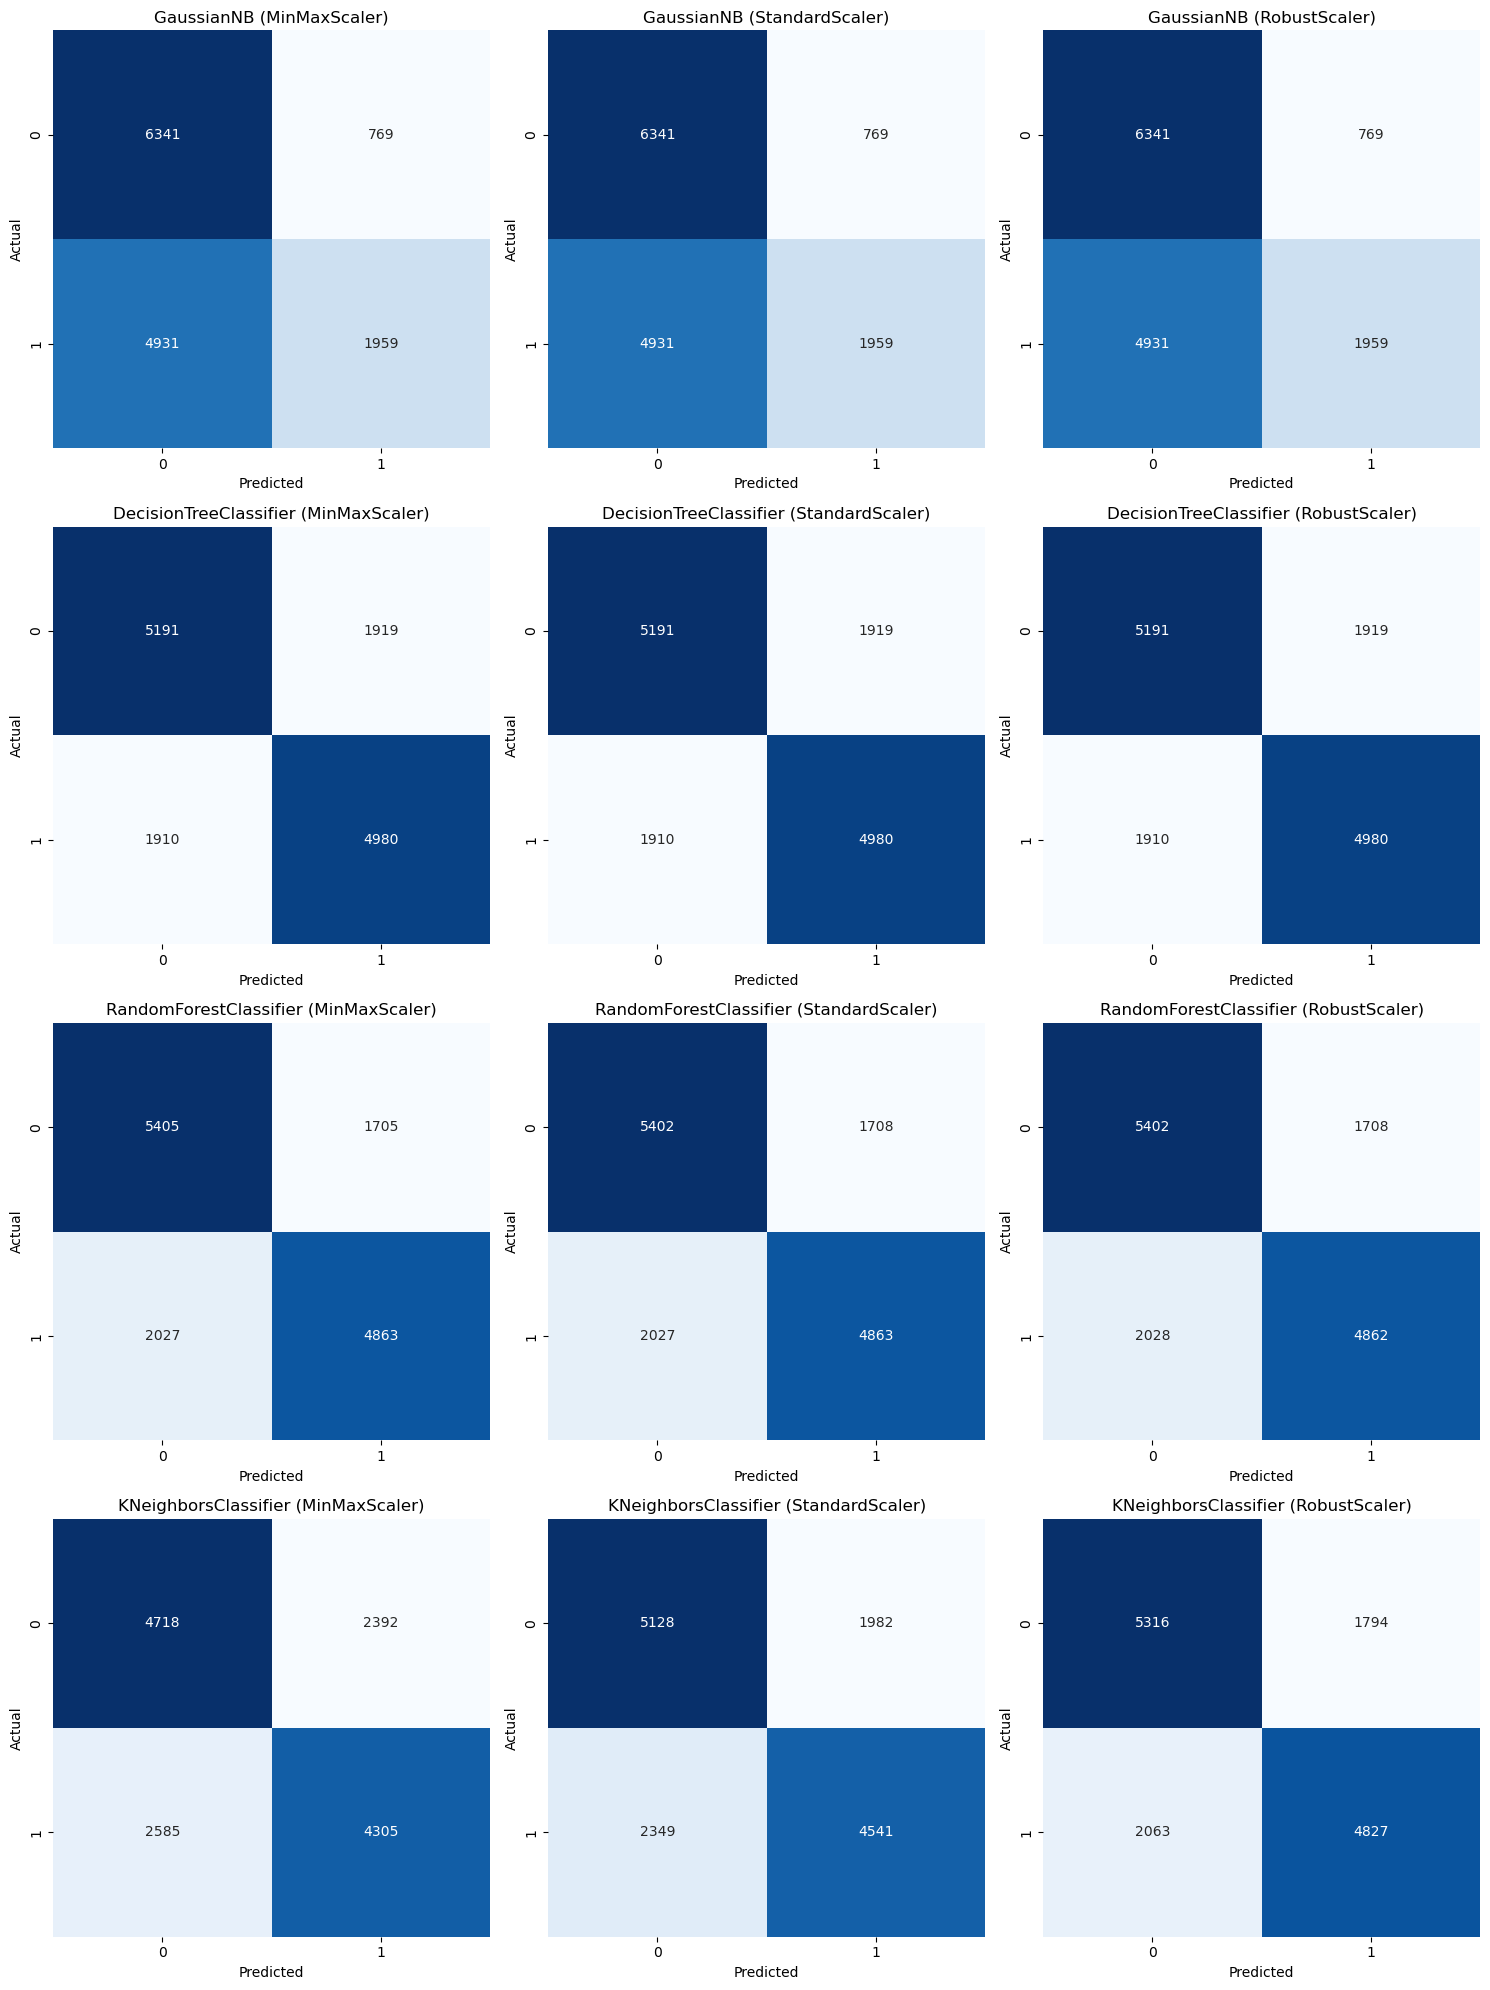

In [20]:
# Visualizing confusion matrices for each model and scaler
from sklearn.metrics import confusion_matrix

num_columns = 3

num_rows = (len(df_results) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5*num_rows))

for index, row in df_results.iterrows():
    model_name = row['Model']
    scaler_name = row['Scaler']

    best_params = row['Best Parameters']

    model = globals()[model_name](**best_params)
    scaler = scalers[scaler_name]

    X_train_scaled = scaled_datasets[scaler_name]
    model.fit(X_train_scaled, y_train)

    X_test_scaled = scale_test_data(X_test, scaler)

    y_pred_test = model.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred_test)

    row, col = divmod(index, num_columns)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[row, col])
    axes[row, col].set_title(f'{model_name} ({scaler_name})')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')


plt.tight_layout()
plt.show()


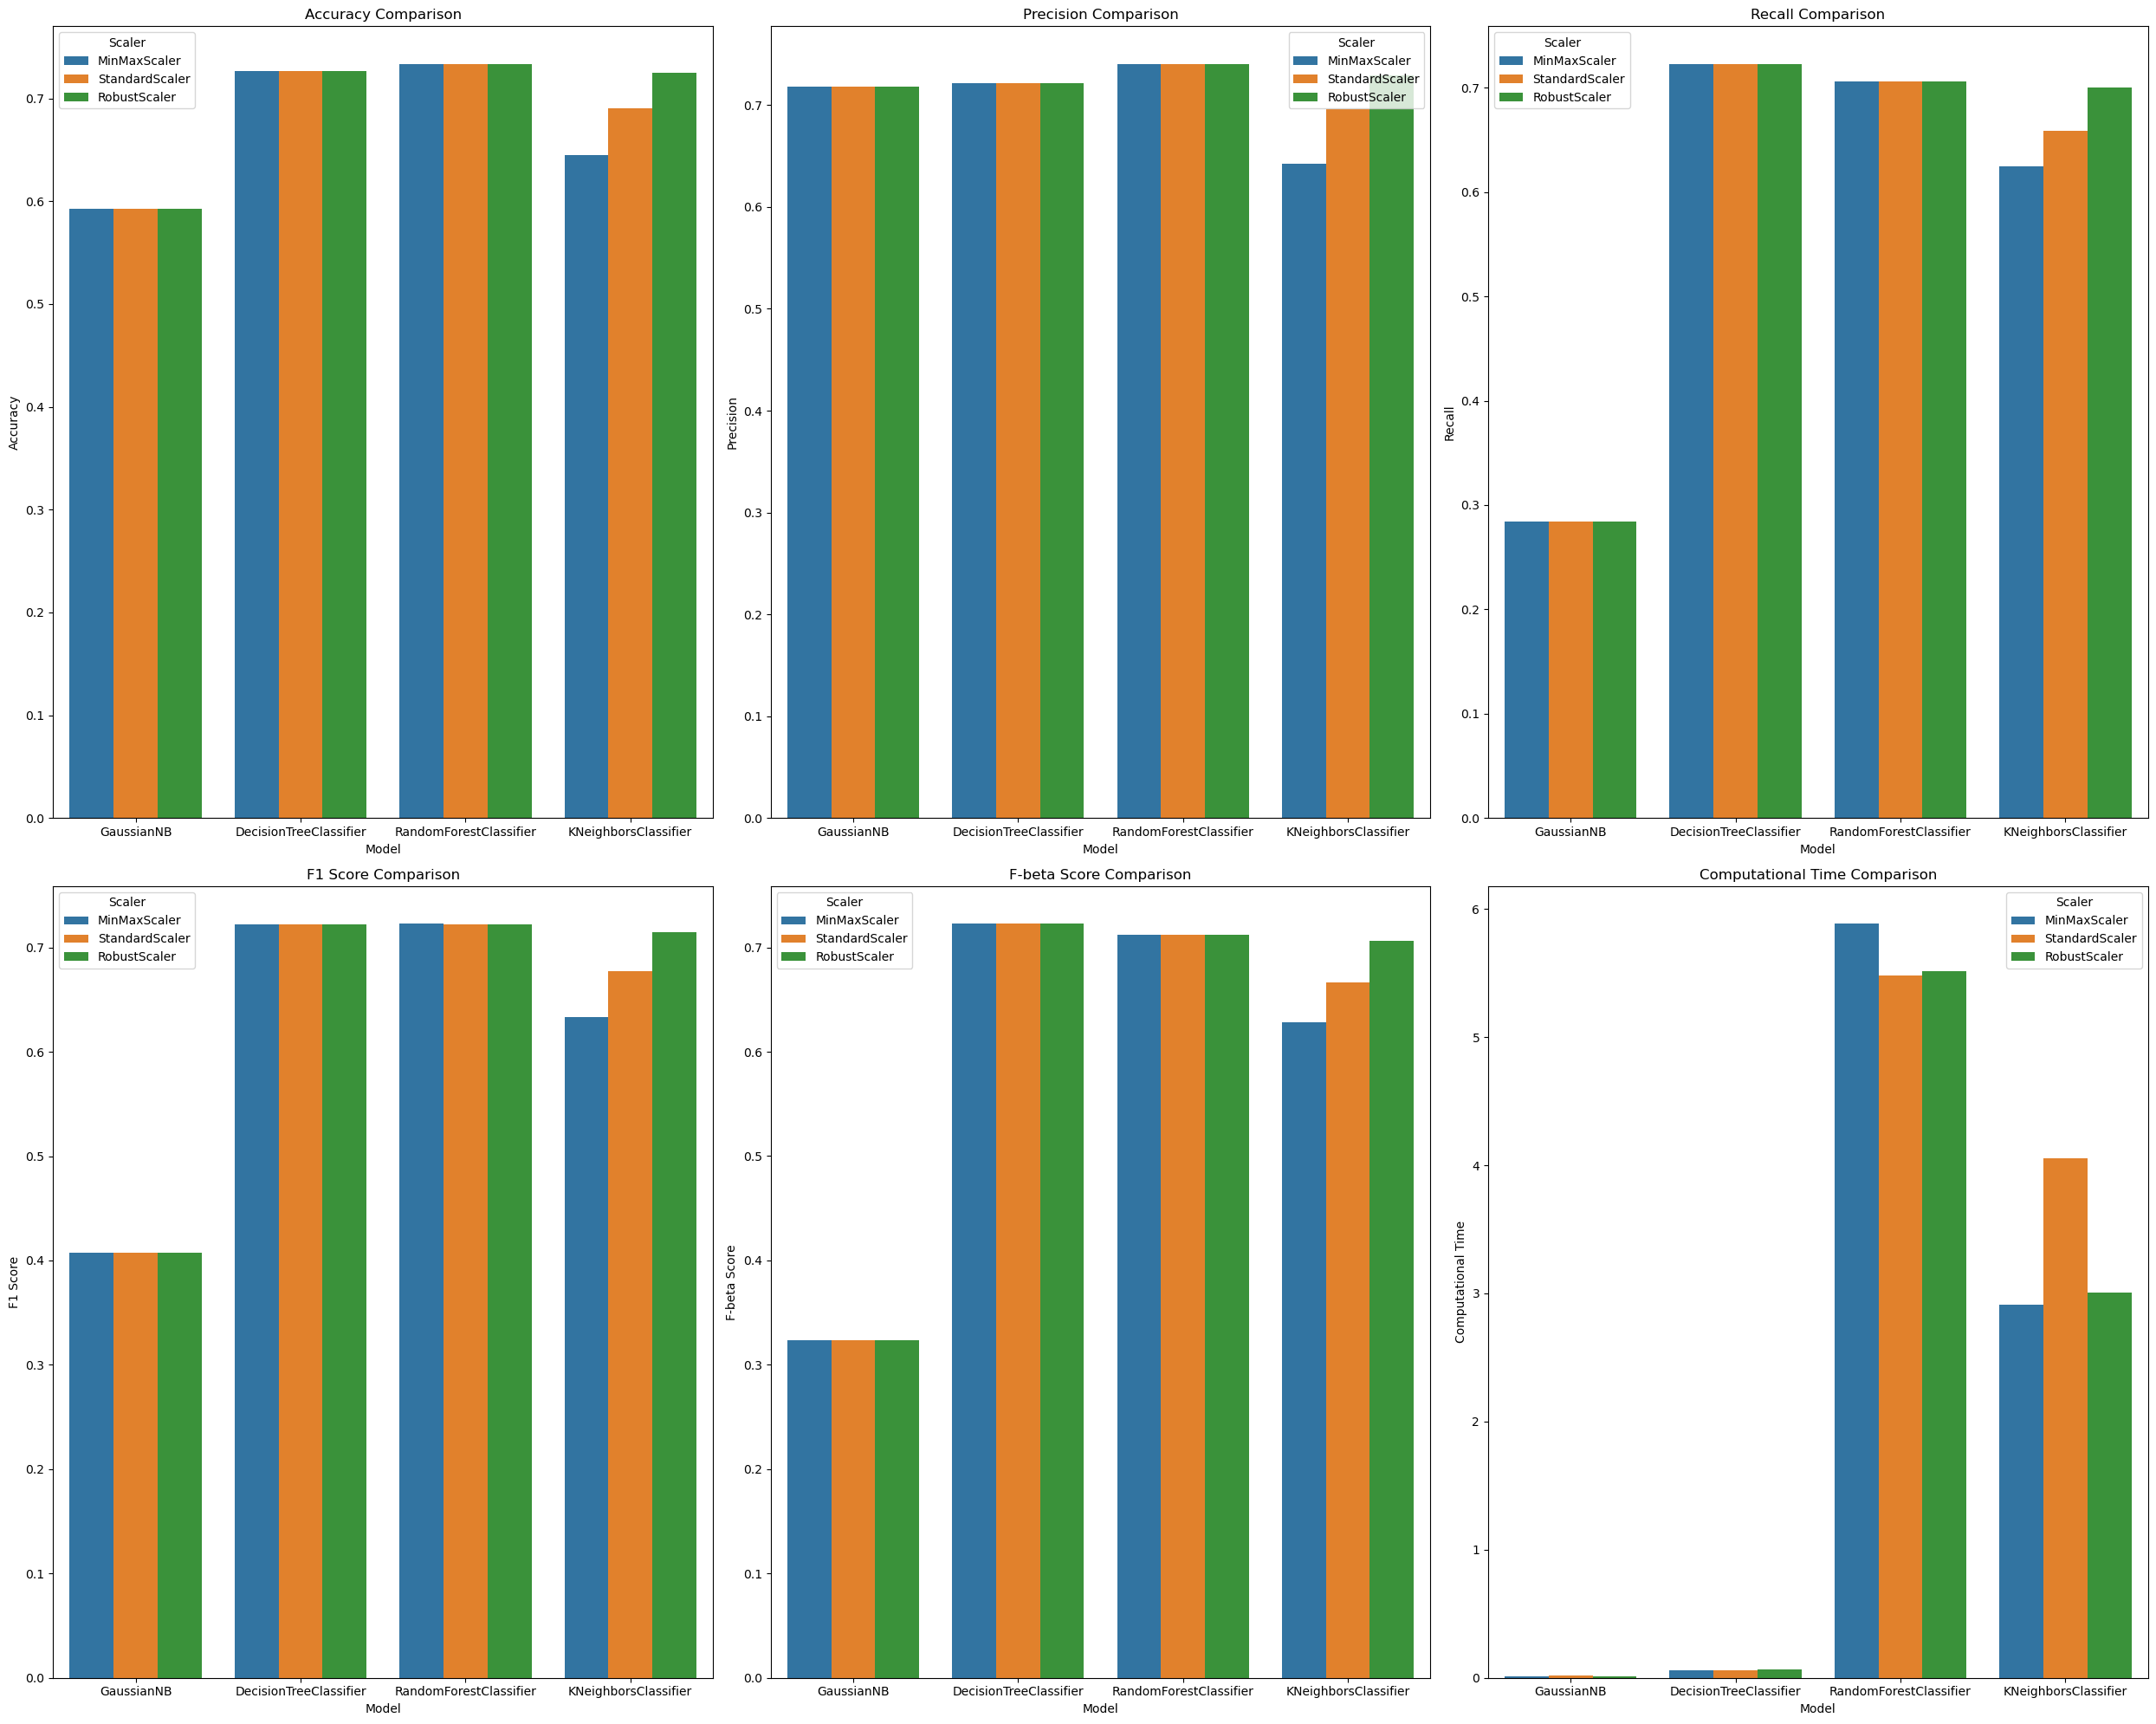

In [21]:
# Visualizing metrics comparison for each model and scaler
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F-beta Score', 'Computational Time']

fig, axes = plt.subplots(2, 3, figsize=(25, 20))
for i, metric in enumerate(metrics_to_plot):
    row, col = divmod(i, 3)
    sns.barplot(data=df_results, x='Model', y=metric, hue='Scaler', ax=axes[row, col])
    axes[row, col].set_title(f'{metric} Comparison')
    axes[row, col].set_ylabel(metric)
plt.tight_layout()
plt.show()



# Logistic Regression
I have also chosen to incorporate Logistic Regression in my analysis of the data.

In [22]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression model for C value of 1
model=LogisticRegression(C=1)
model.fit(X_train_standard_scaled,y_train)


LogisticRegression(C=1)

In [23]:
lr_pred = model.predict(X_test_standard_scaled)

In [24]:
model.predict_proba(X_test_standard_scaled)

array([[0.5763452 , 0.4236548 ],
       [0.98853357, 0.01146643],
       [0.56794707, 0.43205293],
       ...,
       [0.30467945, 0.69532055],
       [0.69131527, 0.30868473],
       [0.38987794, 0.61012206]])

In [25]:
model.score(X_test_standard_scaled,y_test)

0.7231428571428572

In [26]:
fbeta_score(y_test,lr_pred, beta=2)

0.6946160635481023

In [27]:
# Fitting Logistic Regression with different regularization strengths

params, accuracies, recalls, precisions, f1_scores, f2_scores, computational_time = [], [], [], [], [], [], []
for c in np.arange(-15, 15):
    start_time = time.time()
    lr = LogisticRegression(C=10.0**c, random_state=0)
    lr.fit(X_train_standard_scaled, y_train)
    
    params.append(10.0**c)
    
    y_pred = lr.predict(X_test_standard_scaled)
    end_time = time.time()
    accuracies.append(accuracy_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    f2_scores.append(fbeta_score(y_test, y_pred, beta=2))
    computational_time.append(end_time-start_time)

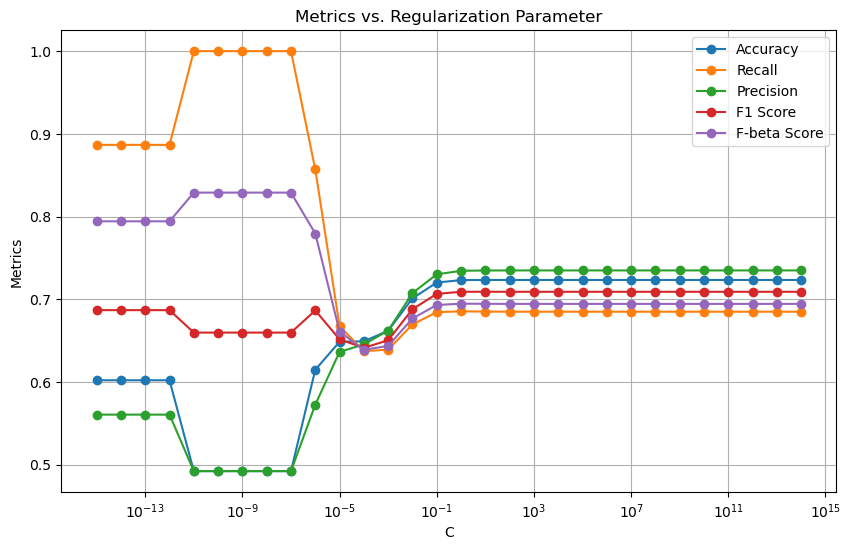

In [28]:
# Plotting the results
plt.figure(figsize=(10, 6))

plt.plot(params, accuracies, label='Accuracy', marker='o')

plt.plot(params, recalls, label='Recall', marker='o')

plt.plot(params, precisions, label='Precision', marker='o')

plt.plot(params, f1_scores, label='F1 Score', marker='o')

plt.plot(params, f2_scores, label='F-beta Score', marker='o')

plt.xlabel('C')
plt.ylabel('Metrics')
plt.xscale('log')
plt.title('Metrics vs. Regularization Parameter')
plt.legend()
plt.grid(True)

plt.show()

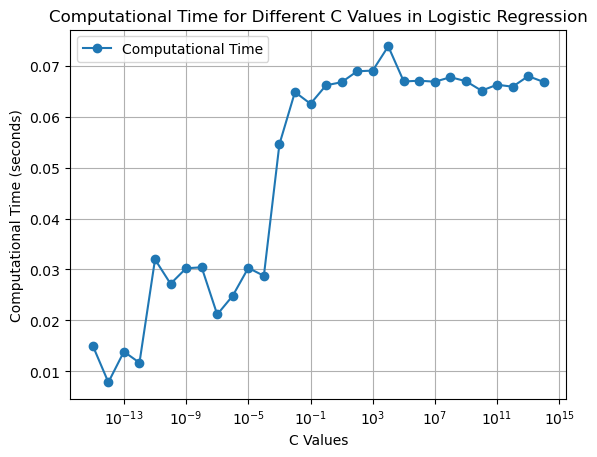

In [29]:
plt.plot(params, computational_time, marker='o', label='Computational Time')

plt.xscale('log')
plt.xlabel('C Values')
plt.ylabel('Computational Time (seconds)')
plt.title('Computational Time for Different C Values in Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()